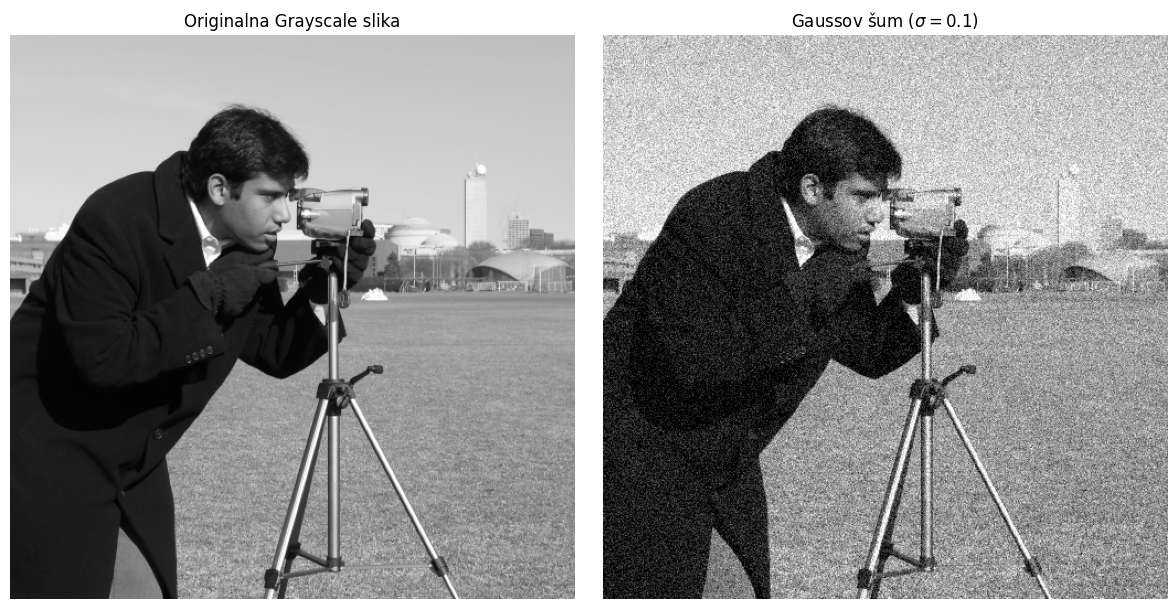

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from skimage import data, img_as_float, color
import cv2

def dodaj_gaussov_sum_gray(slika, mean=0, sigma=0.1):
    
    #Dodaje Gaussov šum na grayscale sliku.
        
    # Generisanje šuma
    gauss = np.random.normal(mean, sigma, slika.shape)
    
    # Aditivni model: Slika + Šum
    noisy_image = slika + gauss
    
    noisy_image = np.clip(noisy_image, 0, 1)
    
    return noisy_image

# Ugrađena grayscale slika (Cameraman)
original_img = img_as_float(data.camera())

# Dodavanje šuma
jacina_suma = 0.1 # Probaj 0.05 za slabiji ili 0.2 za jači šum
img_gauss = dodaj_gaussov_sum_gray(original_img, sigma=jacina_suma)

# Prikaz
plt.figure(figsize=(12, 6))

# Lijeva slika
plt.subplot(1, 2, 1)
plt.imshow(original_img, cmap='gray') 
plt.title("Originalna Grayscale slika")
plt.axis('off')

# Desna slika
plt.subplot(1, 2, 2)
plt.imshow(img_gauss, cmap='gray') 
plt.title(f"Gaussov šum ($\\sigma={jacina_suma}$)")
plt.axis('off')

plt.tight_layout()
plt.show()

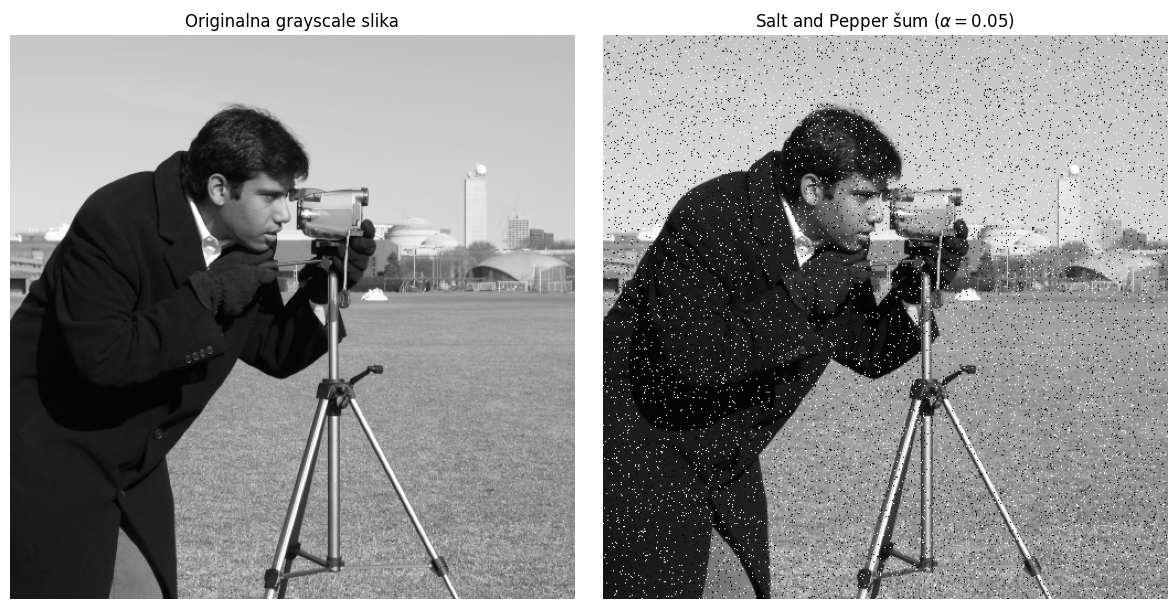

In [3]:
def dodaj_salt_pepper_sum(slika, amount=0.05):
    #Dodaje Salt and Pepper šum na grayscale sliku.
 
    row, col = slika.shape
    out = np.copy(slika)
    
    # Generiše se matricu slučajnih brojeva od 0 do 1 za svaki piksel
    # Ovo simulira vjerovatnoću pojave greške
    probs = np.random.rand(row, col)
    
    # Salt - Bijele tačke
    # Ako je slučajni broj manji od alpha/2, piksel postaje 1.0 (Bijelo)
    out[probs < (amount / 2)] = 1
    
    # Pepper - Crne tačke
    # Ako je slučajni broj veći od 1 - alpha/2, piksel postaje 0.0 (Crno)
    out[probs > (1 - amount / 2)] = 0
    
    return out

# Slika fotografa
img_gray = img_as_float(data.camera())

# Ddavanje šuma
img_SnP = dodaj_salt_pepper_sum(img_gray, amount=0.05)

plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.imshow(img_gray, cmap='gray')
plt.title("Originalna grayscale slika")
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(img_SnP, cmap='gray')
plt.title("Salt and Pepper šum ($\\alpha=0.05$)")
plt.axis('off')

plt.tight_layout()
plt.show()

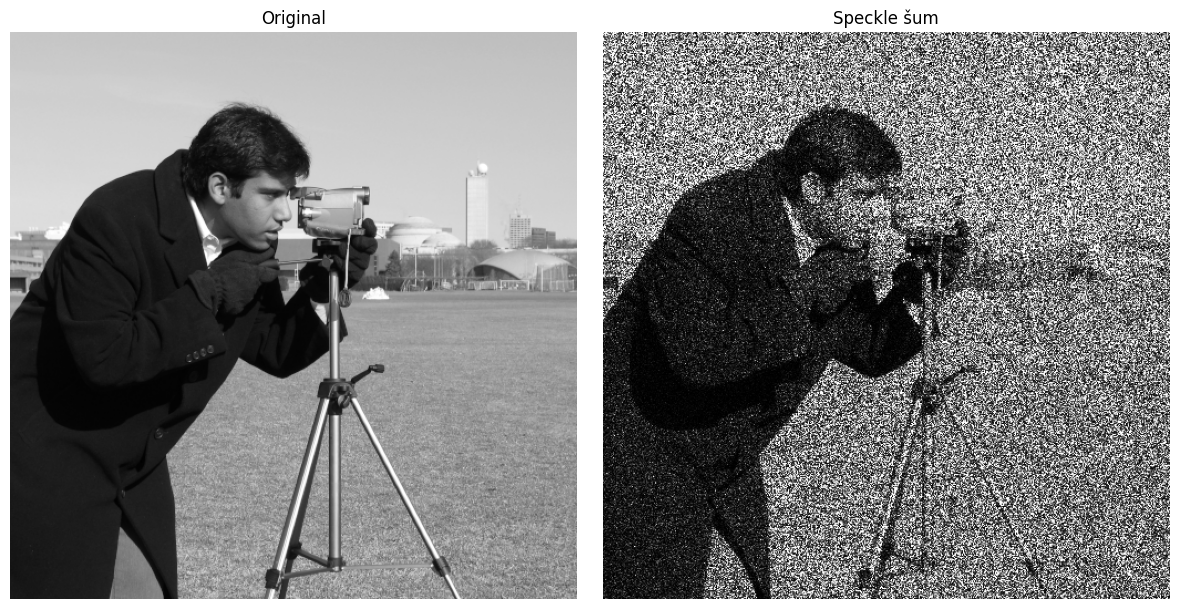

In [91]:
def dodaj_speckle(slika):
   
    # Generisanje šuma eksponencijalne raspodjele
    # scale=1.0 znači da je srednja vrijednost 1
    q_sum = np.random.exponential(scale=1.0, size=slika.shape)
    
    # Multiplikativni model
    speckle_slika = slika * q_sum
    
    speckle_slika = np.clip(speckle_slika, 0, 1)
    
    return speckle_slika

img_gray = img_as_float(data.camera())

img_speckle = dodaj_speckle(img_gray)

# Prikaz
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.imshow(img_gray, cmap='gray')
plt.title("Original")
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(img_speckle, cmap='gray')
plt.title("Speckle šum")
plt.axis('off')

plt.tight_layout()
plt.show()

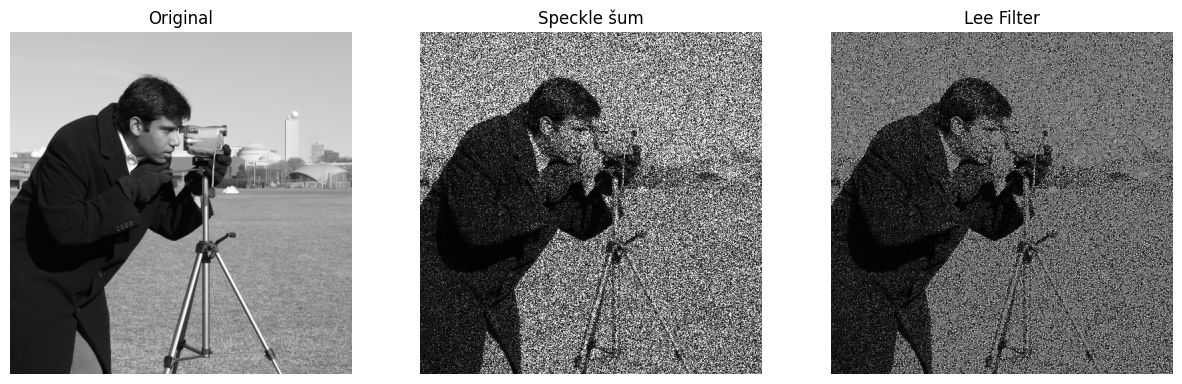

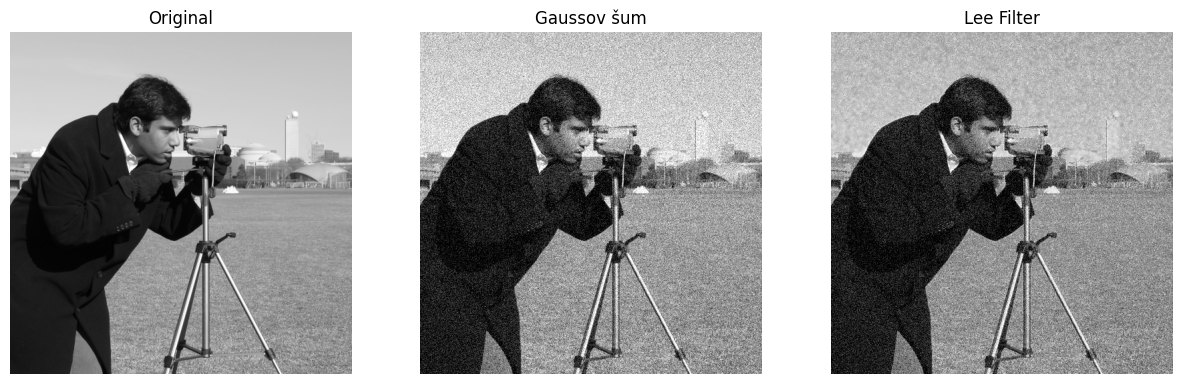

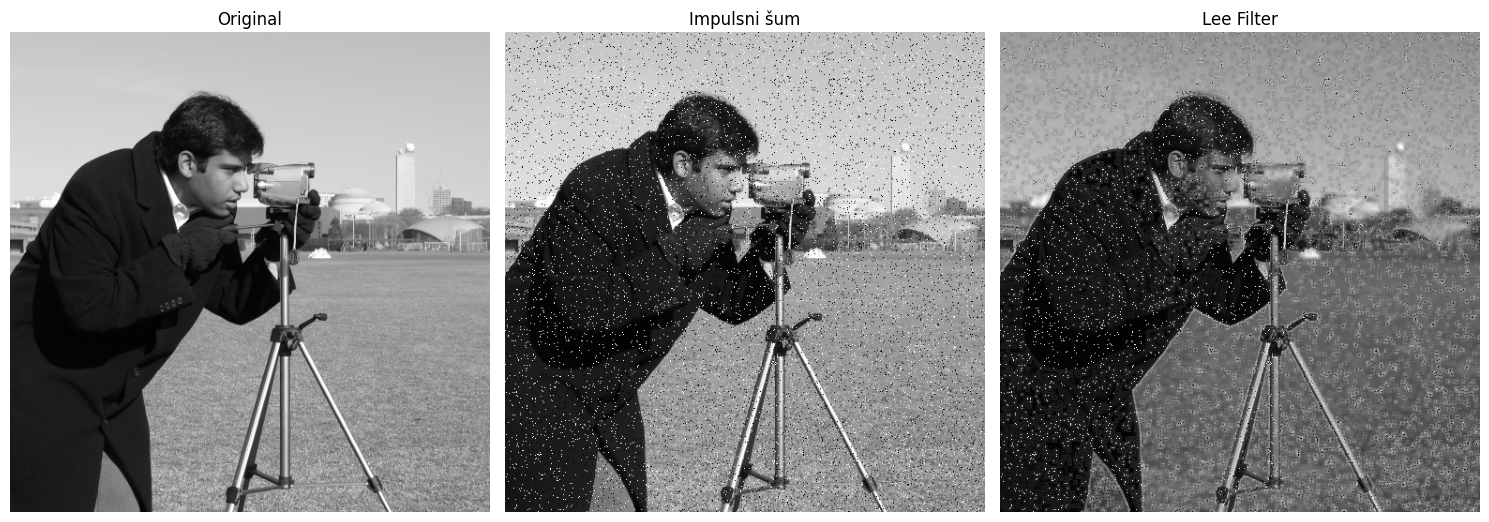

In [92]:
import numpy as np
import matplotlib.pyplot as plt
from skimage import data, img_as_float
from scipy.ndimage import uniform_filter

def lee_filter(slika, velicina_prozora=5, mean_suma=1.0, varijansa_suma=1.0):
    
    # 1. Lokalna statistika zasumljene slike 
    m_z = uniform_filter(slika, (velicina_prozora, velicina_prozora)) # mean of z
    var_z = uniform_filter(slika**2, (velicina_prozora, velicina_prozora)) - m_z**2 # variance of z
    
    # Procijena lokalne statistiku originalne slike
    # m_x = m_z / m_u
    # var_x = (var_z + m_z^2) / (var_u + m_u^2) - (m_z/m_u)^2
    
    m_x = m_z / mean_suma
    var_x = (var_z + m_z**2) / (varijansa_suma + mean_suma**2) - m_x**2
    var_x = np.maximum(var_x, 0) # Varijansa ne može biti negativna
    
    # Računanje težinskog faktora (k) 
    # k = (u_mean * var_x) / (x_mean^2 * var_u + u_mean^2 * var_x)
    
    brojnik = mean_suma * var_x
    nazivnik = (m_x**2 * varijansa_suma) + (mean_suma**2 * var_x)
    
    k = brojnik / np.maximum(nazivnik, 1e-8) # Izbjegavamo dijeljenje nulom
    
    # Finalna formula filtera
    # f_hat = m_x + k * (z - u_mean * m_x)
    
    izlaz = m_x + k * (slika - mean_suma * m_x)
    
    return np.clip(izlaz, 0, 1)


original = img_as_float(data.camera())

mean_noise = 1.0
var_noise = 1.0
speckle_noise = np.random.exponential(scale=mean_noise, size=original.shape)
img_speckle = np.clip(original * speckle_noise, 0, 1)

# Primjena Lee filtra
restaurirana_lee_orig = lee_filter(img_speckle, 
                                            velicina_prozora=5, 
                                            mean_suma=mean_noise,
                                            varijansa_suma=var_noise/2)
restaurirana_lee_gauss = lee_filter(img_gauss, 
                                            velicina_prozora=5, 
                                            mean_suma=1.0,
                                            varijansa_suma=jacina_suma**2)

restaurirana_lee_SnP = lee_filter(img_SnP, 
                                            velicina_prozora=5, 
                                            mean_suma=1.0,
                                            varijansa_suma=0.1
                                            )

# 3. Prikaz
plt.figure(figsize=(15, 6))
plt.subplot(1, 3, 1); plt.title("Original"); plt.imshow(original, cmap='gray'); plt.axis('off')
plt.subplot(1, 3, 2); plt.title("Speckle šum"); plt.imshow(img_speckle, cmap='gray'); plt.axis('off')
plt.subplot(1, 3, 3); plt.title("Lee Filter"); plt.imshow(restaurirana_lee_orig, cmap='gray'); plt.axis('off')
plt.figure(figsize=(15, 6))
plt.subplot(1, 3, 1); plt.title("Original"); plt.imshow(original, cmap='gray'); plt.axis('off')
plt.subplot(1, 3, 2); plt.title("Gaussov šum"); plt.imshow(img_gauss, cmap='gray'); plt.axis('off')
plt.subplot(1, 3, 3); plt.title("Lee Filter"); plt.imshow(restaurirana_lee_gauss, cmap='gray'); plt.axis('off')
plt.figure(figsize=(15, 6))
plt.subplot(1, 3, 1); plt.title("Original"); plt.imshow(original, cmap='gray'); plt.axis('off')
plt.subplot(1, 3, 2); plt.title("Impulsni šum"); plt.imshow(img_SnP, cmap='gray'); plt.axis('off')
plt.subplot(1, 3, 3); plt.title("Lee Filter"); plt.imshow(restaurirana_lee_SnP, cmap='gray'); plt.axis('off')
plt.tight_layout()
plt.show()

In [90]:
from skimage.metrics import peak_signal_noise_ratio as psnr
from skimage.metrics import mean_squared_error as mse
from skimage.metrics import structural_similarity as ssim

# Uporedi original sa zašumljenom
mse_prije1 = mse(original, img_speckle)
mse_prije2 = mse(original, img_gauss)
mse_prije3 = mse(original, img_SnP)

# Uporedi original sa filtriranom
mse_poslije1 = mse(original, restaurirana_lee_orig)
mse_poslije2 = mse(original, restaurirana_lee_gauss)
mse_poslije3 = mse(original, restaurirana_lee_SnP)

psnr_prije1 = psnr(original, img_speckle)
psnr_prije2 = psnr(original, img_gauss)
psnr_prije3 = psnr(original, img_SnP)

psnr_poslije1 = psnr(original, restaurirana_lee_orig)
psnr_poslije2 = psnr(original, restaurirana_lee_gauss)
psnr_poslije3 = psnr(original, restaurirana_lee_SnP)

print(f"PSNR (Speckle): {psnr_prije1:.2f} dB  -->  {psnr_poslije1:.2f} dB")
print(f"PSNR (Gauss): {psnr_prije2:.2f} dB  -->  {psnr_poslije2:.2f} dB ")
print(f"PSNR (Salt and Pepper): {psnr_prije3:.2f} dB  -->  {psnr_poslije3:.2f} dB")

print(f"MSE (Speckle):  {mse_prije1:.4f}     -->  {mse_poslije1:.4f}")
print(f"MSE (Gauss):  {mse_prije2:.4f}     -->  {mse_poslije2:.4f} ")
print(f"MSE (Salt and Pepper):  {mse_prije3:.4f}     -->  {mse_poslije3:.4f} ")

PSNR (Speckle): 9.53 dB  -->  10.37 dB
PSNR (Gauss): 20.45 dB  -->  20.62 dB 
PSNR (Salt and Pepper): 17.72 dB  -->  14.96 dB
MSE (Speckle):  0.1114     -->  0.0919
MSE (Gauss):  0.0090     -->  0.0087 
MSE (Salt and Pepper):  0.0169     -->  0.0319 


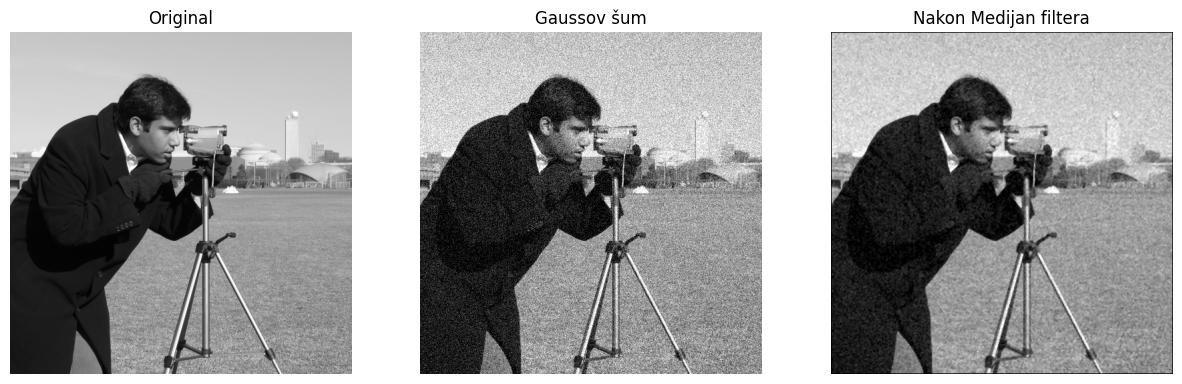

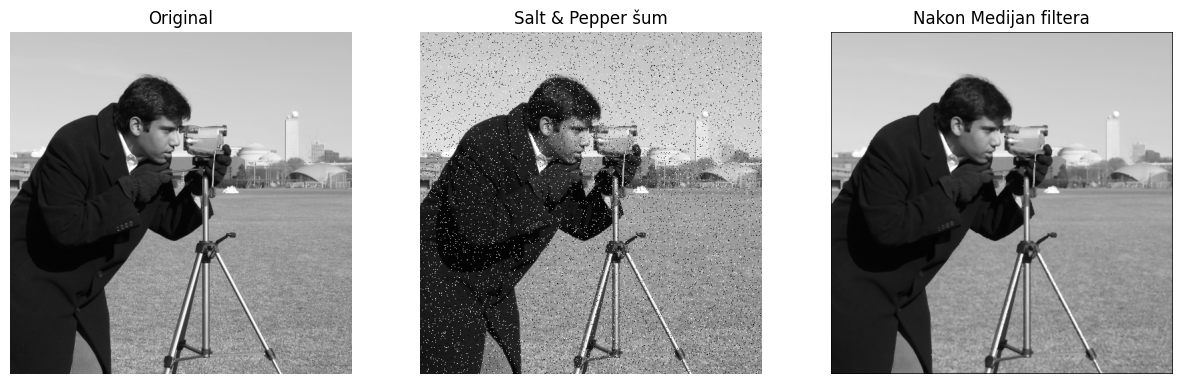

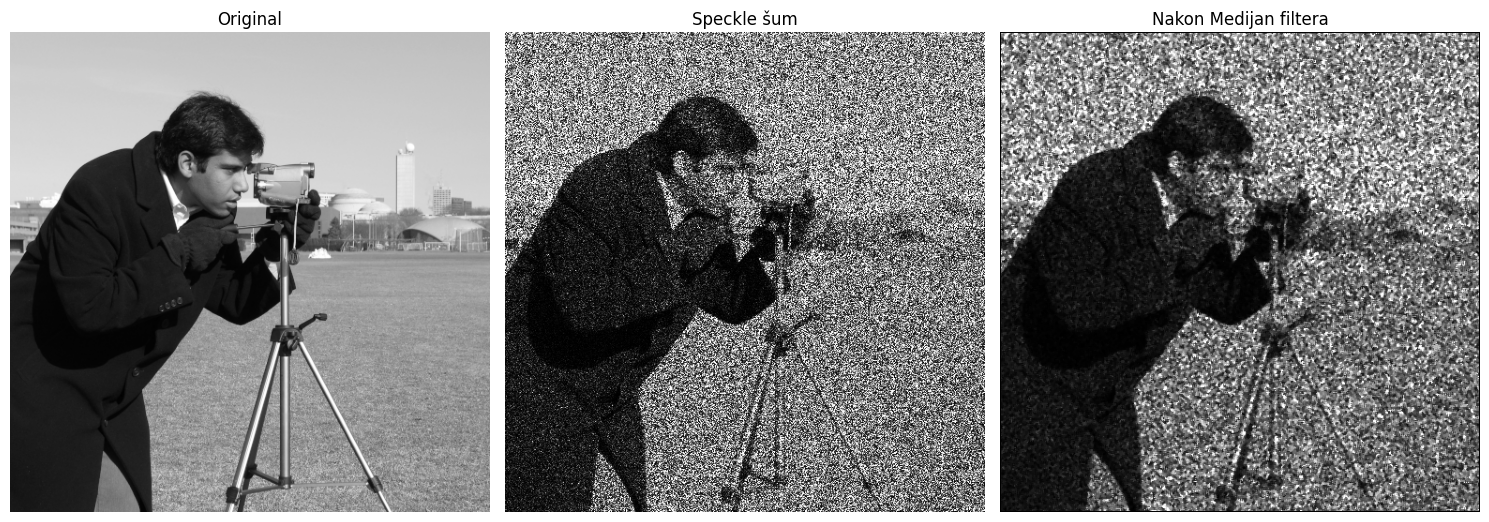

In [20]:
import numpy as np
import matplotlib.pyplot as plt
from skimage import data, img_as_float

def median_filter(slika, velicina_prozora=3):
    
    visina, sirina = slika.shape
    izlaz = np.zeros((visina, sirina))
    
    offset = velicina_prozora // 2
    
    # Prolaz kroz svaki piksel slike
    for i in range(offset, visina - offset):
        for j in range(offset, sirina - offset):
            
            # Definisanje okoline (klizni prozor)
            okolina = slika[i-offset : i+offset+1, j-offset : j+offset+1]
            
            # Prikupljanje u niz i sortiranje
            sortirani_niz = np.sort(okolina.ravel())
            
            # Odabir medijane (srednji element)
            srednji_indeks = len(sortirani_niz) // 2
            medijana = sortirani_niz[srednji_indeks]
            
            # Zamjena originalnog piksela
            izlaz[i, j] = medijana
            
    return izlaz

# 1. Originalna slika
original = img_as_float(data.camera())


# 3. Primjena medijan filtera (prozor 3x3)
restaurirana_median = median_filter(img_SnP, velicina_prozora=3)

#za gaussov
restaurirana_median_gauss = median_filter(img_gauss, velicina_prozora=3)

#za speckle
restaurirana_median_speckle = median_filter(img_speckle, velicina_prozora=3)

# 4. Prikaz
plt.figure(figsize=(15, 6))

plt.subplot(1, 3, 1)
plt.imshow(original, cmap='gray')
plt.title("Original")
plt.axis('off')

plt.subplot(1, 3, 2)
plt.imshow(zasumljena_slika_gauss, cmap='gray')
plt.title("Gaussov šum")
plt.axis('off')

plt.subplot(1, 3, 3)
plt.imshow(restaurirana_median_gauss, cmap='gray')
plt.title("Nakon Medijan filtera")
plt.axis('off')

plt.figure(figsize=(15, 6))
plt.subplot(1, 3, 1)
plt.imshow(original, cmap='gray')
plt.title("Original")
plt.axis('off')

plt.subplot(1, 3, 2)
plt.imshow(img_SnP, cmap='gray')
plt.title("Salt & Pepper šum")
plt.axis('off')

plt.subplot(1, 3, 3)
plt.imshow(restaurirana_median, cmap='gray')
plt.title("Nakon Medijan filtera")
plt.axis('off')

plt.figure(figsize=(15, 6))
plt.subplot(1, 3, 1)
plt.imshow(original, cmap='gray')
plt.title("Original")
plt.axis('off')

plt.subplot(1, 3, 2)
plt.imshow(img_speckle, cmap='gray')
plt.title("Speckle šum")
plt.axis('off')

plt.subplot(1, 3, 3)
plt.imshow(restaurirana_median_speckle, cmap='gray')
plt.title("Nakon Medijan filtera")
plt.axis('off')

plt.tight_layout()
plt.show()

In [43]:
# Uporedi original sa zašumljenom 
mse_prije1 = mse(original, img_speckle)
mse_prije2 = mse(original, img_gauss)
mse_prije3 = mse(original, img_SnP)

# Uporedi original sa filtriranom 
mse_poslije1 = mse(original, restaurirana_median_speckle)
mse_poslije2 = mse(original, restaurirana_median_gauss)
mse_poslije3 = mse(original, restaurirana_median)

psnr_prije1 = psnr(original, img_speckle)
psnr_prije2 = psnr(original, img_gauss)
psnr_prije3 = psnr(original, img_SnP)

psnr_poslije1 = psnr(original, restaurirana_median_speckle)
psnr_poslije2 = psnr(original, restaurirana_median_gauss)
psnr_poslije3 = psnr(original, restaurirana_median)

print(f"PSNR (Speckle): {psnr_prije1:.2f} dB  -->  {psnr_poslije1:.2f} dB")
print(f"PSNR (Gauss): {psnr_prije2:.2f} dB  -->  {psnr_poslije2:.2f} dB ")
print(f"PSNR (Salt and Pepper): {psnr_prije3:.2f} dB  -->  {psnr_poslije3:.2f} dB")

print(f"MSE (Salt and Pepper):  {mse_prije1:.4f}     -->  {mse_poslije1:.4f}")
print(f"MSE (Gauss):  {mse_prije2:.4f}     -->  {mse_poslije2:.4f} ")
print(f"MSE (Speckle):  {mse_prije3:.4f}     -->  {mse_poslije3:.4f} ")

PSNR (Speckle): 9.52 dB  -->  12.17 dB
PSNR (Gauss): 20.45 dB  -->  22.40 dB 
PSNR (Salt and Pepper): 17.72 dB  -->  23.90 dB
MSE (Salt and Pepper):  0.1116     -->  0.0607
MSE (Gauss):  0.0090     -->  0.0057 
MSE (Speckle):  0.0169     -->  0.0041 


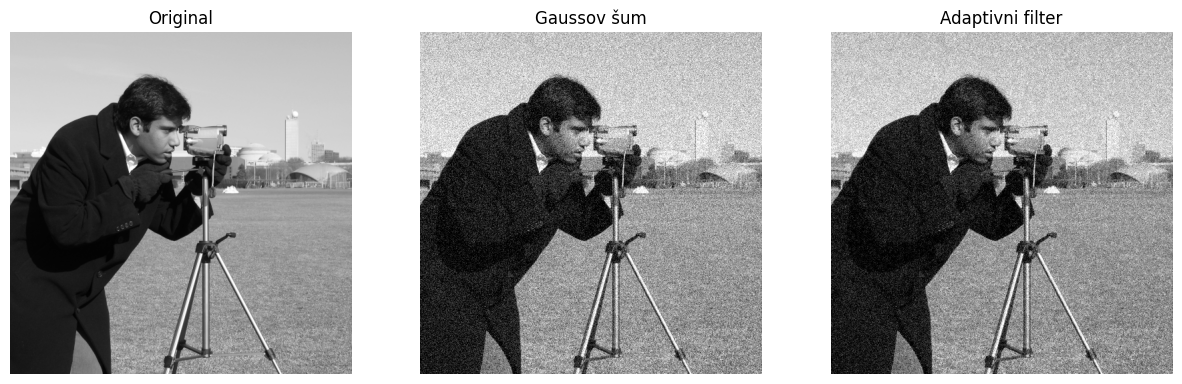

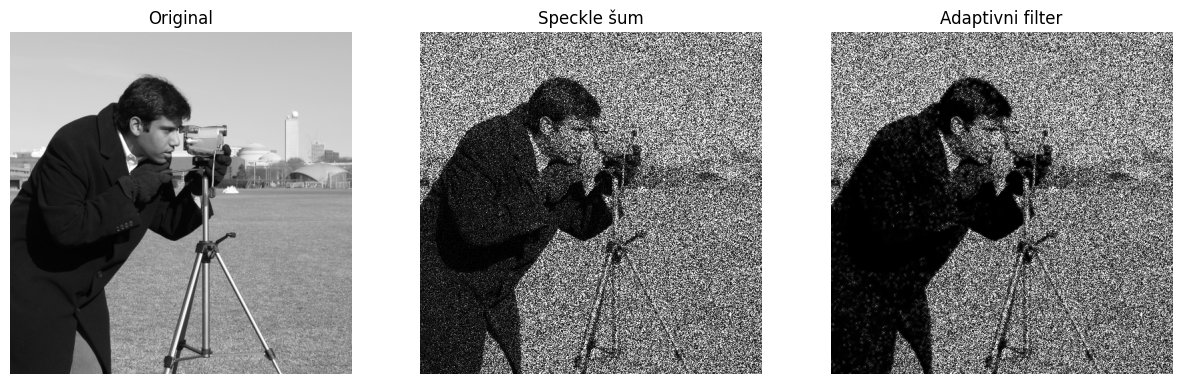

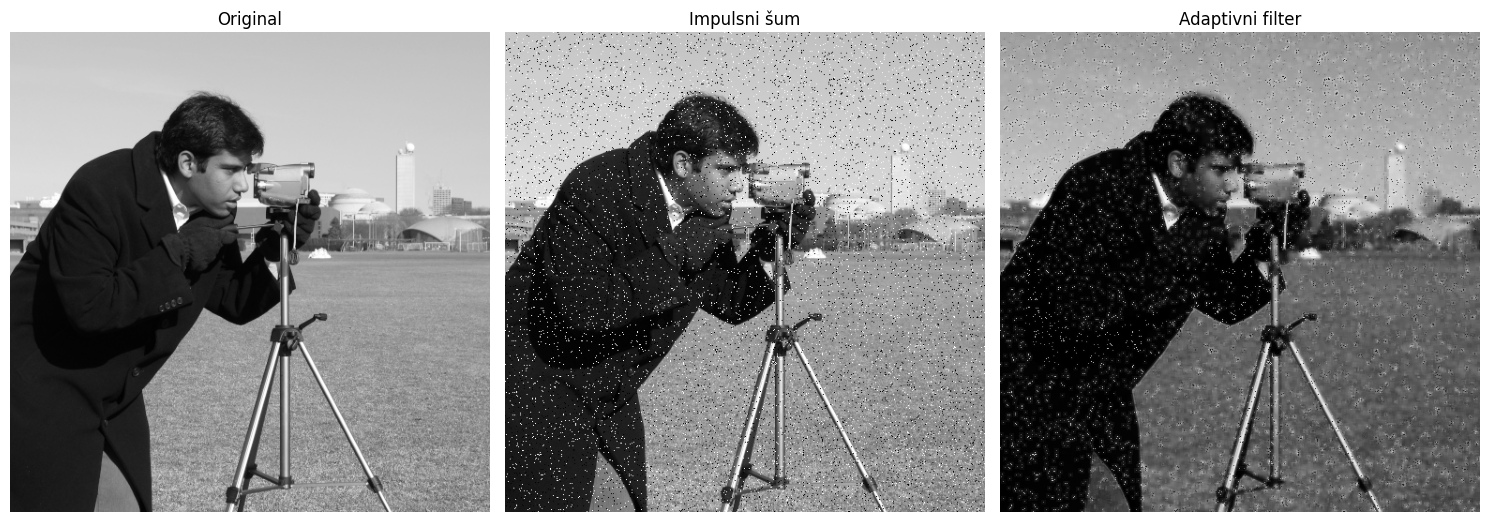

In [93]:
import numpy as np
import matplotlib.pyplot as plt
from skimage import data, img_as_float
from scipy.ndimage import uniform_filter

def adaptive_filter(slika, velicina_prozora=5, varijansa_suma=None):
    
    # Izračunaj lokalnu srednju vrijednost (m_L)
    m_L = uniform_filter(slika, (velicina_prozora, velicina_prozora))
    
    # Izračunaj lokalnu varijansu (sigma^2_L)
    mean_sq = uniform_filter(slika**2, (velicina_prozora, velicina_prozora))
    # Var(x) = E[x^2] - (E[x])^2
    sigma_L_sq = mean_sq - m_L**2
    
    # Procjena varijanse šuma (sigma^2_eta)
    if varijansa_suma is None:
        # Ako nije data, procijeni kao prosjek svih lokalnih varijansi
        sigma_eta_sq = np.mean(sigma_L_sq)
    else:
        sigma_eta_sq = varijansa_suma
        
    epsilon = 1e-8
    tezinski_faktor = sigma_eta_sq / (sigma_L_sq + epsilon)
    
    tezinski_faktor = np.minimum(tezinski_faktor, 1.0)
    
    razlika = slika - m_L
    
    # Konačna formula: g - (Faktor * Razlika)
    izlaz = slika - (tezinski_faktor * razlika)
    
    return np.clip(izlaz, 0, 1)

var_noise = jacina_suma**2; #st. dev ^2

restaurirana_adaptivna_gauss = adaptive_filter(img_gauss, 
                                        velicina_prozora=5, 
                                        varijansa_suma=var_noise/10)

restaurirana_adaptivna_speckle = adaptive_filter(img_speckle, 
                                        velicina_prozora=5, 
                                        varijansa_suma=0.01)

restaurirana_adaptivna_sNp = adaptive_filter(img_SnP, 
                                        velicina_prozora=5, 
                                        varijansa_suma=None)
# 3. Prikaz
plt.figure(figsize=(15, 6))

plt.subplot(1, 3, 1)
plt.imshow(original_img, cmap='gray')
plt.title("Original")
plt.axis('off')

plt.subplot(1, 3, 2)
plt.imshow(img_gauss, cmap='gray')
plt.title(f"Gaussov šum")
plt.axis('off')

plt.subplot(1, 3, 3)
plt.imshow(restaurirana_adaptivna_gauss, cmap='gray')
plt.title("Adaptivni filter")
plt.axis('off')

plt.figure(figsize=(15, 6))
plt.subplot(1, 3, 1)
plt.imshow(original_img, cmap='gray')
plt.title("Original")
plt.axis('off')

plt.subplot(1, 3, 2)
plt.imshow(img_speckle, cmap='gray')
plt.title(f"Speckle šum")
plt.axis('off')

plt.subplot(1, 3, 3)
plt.imshow(restaurirana_adaptivna_speckle, cmap='gray')
plt.title("Adaptivni filter")
plt.axis('off')

plt.figure(figsize=(15, 6))
plt.subplot(1, 3, 1)
plt.imshow(original_img, cmap='gray')
plt.title("Original")
plt.axis('off')

plt.subplot(1, 3, 2)
plt.imshow(img_SnP, cmap='gray')
plt.title(f"Impulsni šum")
plt.axis('off')

plt.subplot(1, 3, 3)
plt.imshow(restaurirana_adaptivna_sNp, cmap='gray')
plt.title("Adaptivni filter")
plt.axis('off')

plt.tight_layout()
plt.show()

In [53]:
# Uporedi ORIGINAL sa ZAŠUMLJENOM (da vidiš kolika je šteta)
mse_prije1 = mse(original, img_speckle)
mse_prije2 = mse(original, img_gauss)
mse_prije3 = mse(original, img_SnP)

# Uporedi ORIGINAL sa FILTRIRANOM (da vidiš jesi li popravila)
mse_poslije3 = mse(original, restaurirana_adaptivna_sNp)
mse_poslije2 = mse(original, restaurirana_adaptivna_gauss)
mse_poslije1 = mse(original, restaurirana_adaptivna_speckle)

psnr_prije1 = psnr(original, img_speckle)
psnr_prije2 = psnr(original, img_gauss)
psnr_prije3 = psnr(original, img_SnP)

psnr_poslije1 = psnr(original, restaurirana_adaptivna_speckle)
psnr_poslije2 = psnr(original, restaurirana_adaptivna_gauss)
psnr_poslije3 = psnr(original, restaurirana_adaptivna_sNp)

print(f"PSNR (Speckle): {psnr_prije1:.2f} dB  -->  {psnr_poslije1:.2f} dB (Cilj: Povećanje)")
print(f"PSNR (Gauss): {psnr_prije2:.2f} dB  -->  {psnr_poslije2:.2f} dB (Cilj: Povećanje)")
print(f"PSNR (Salt and Pepper): {psnr_prije3:.2f} dB  -->  {psnr_poslije3:.2f} dB (Cilj: Povećanje)")

print(f"MSE (Gauss):  {mse_prije2:.4f}     -->  {mse_poslije2:.4f} ")
print(f"MSE (Speckle):  {mse_prije1:.4f}     -->  {mse_poslije1:.4f} ")
print(f"MSE (Salt and Pepper):  {mse_prije3:.4f}     -->  {mse_poslije3:.4f}")

PSNR (Speckle): 9.52 dB  -->  9.89 dB (Cilj: Povećanje)
PSNR (Gauss): 20.45 dB  -->  20.94 dB (Cilj: Povećanje)
PSNR (Salt and Pepper): 17.72 dB  -->  14.91 dB (Cilj: Povećanje)
MSE (Gauss):  0.0090     -->  0.0081 
MSE (Speckle):  0.1116     -->  0.1025 
MSE (Salt and Pepper):  0.0169     -->  0.0323
